# The Shallow Ice Approximation

Is ice a solid or a fluid? 

In fact, solids and fluids are often not mutually exclusive categories. The distinction, instead, is a matter of timescale. If you take an ice cube out of your freezer and hit it with a hammer, it shatters like glass, exhibiting the trademark brittle behaviour of elastic solids. However, if you applied the same force gradually, that ice cube would slowly deform as if it were made of molasses. 

Glaciers behave the same way. Although intense forces can result in sudden, solid-like behaviour - like crevassing and iceberg calving - over long timespans, glaciers behave like thick, viscous fluids oozing outward under the force of their own weight. The laws that govern glacier dynamics, therefore, are the same laws that govern fluid dynamics. These are called the Navier-Stokes Equations, and they are notoriously hard to solve. In fact, there is a standing million-dollar prize for anyone who can prove the existence of a general solution to these equations. Modeling a single glacier with the full Navier-Stokes Equations can take weeks.

Instead, glaciologists often consider approximations to these equations, where terms deemed "unimportant" in certain environments are left out. This vastly simplifies the mathematics - and the computational cost. There are several common approximations used by glaciologists in different physical settings. Here we'll construct at one of the simplest: the Shallow Ice Approximation.  

## Setting up the glacier geometry

To make the mathematics as simple as possible, we'll construct a glacier flowline model. This means we ignore any flow-resisting forces originating from the sides, and we consider only the long, thin slice along the centerline. This lets us simplify to two dimensions, with $x$ the along-flow direction, and $z$ the vertical direction. The glacier will be dome-shaped, with its highest point at $x = 0$, resting on flat bedrock. 

Choose the geometry of the glacier below. We can also choose a mesh resolution, which corresponds to how finely we want to evaluate our solutions. 


In [1]:
x_t = 50000 #location of the glacier terminus (m)
x_0 = 0 #the left boundary of the domain (m), with x = 0 underneath the highest point
# x_0 = -x_t
dome_height = 1000 #the highest point of the glacier (m)

Δx, Δz = 100, 1 #the grid size on which we'll evaluate our solutions (m)

With these initial geometry choices made, we can finish setting up the domain:

In [2]:
import numpy as np

L = x_t - x_0 #the length of the domain (m)
nx = int(L/Δx) #number of grid cells = domain length / cell size
x = np.linspace(x_0, x_t, nx) #set up the array of x-coordinates
b = np.zeros_like(x)
# b =  0.05*dome_height*(np.cos(2*np.pi*x*10/L) + 1)
s = dome_height/x_t*np.sqrt(x_t**2 - x**2) #surface elevations (m)

s[s < b] = np.nan
b[np.isnan(s)] = np.nan

nz = int(dome_height/Δz) #number of grid cells in the vertical direction
z = np.linspace(0, dome_height, nz) #set up the array of z-coordinates

Now we can plot the glacier cross-section we'll be working with. 

*_How different does the glacier look if we set ```x_0 = -x_t``` in Cell 1, so that the domain is symmetric about the dome apex? What real-life cryosphere features have this shape?_*

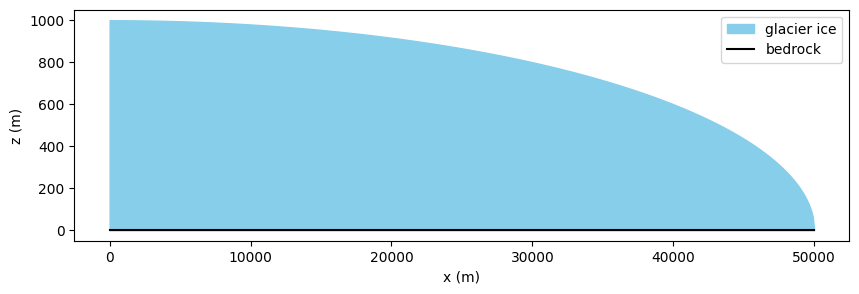

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 3))
plt.fill_between(x, b, s, color = 'skyblue', label = 'glacier ice')
plt.plot(x, b, color = 'k', label = 'bedrock')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.legend(loc = 'upper right')
plt.show()

Finally, we'll describe the grid over which we'll eventually compute our solutions:

In [4]:
z = np.linspace(0, dome_height, nz)
X, Z = np.meshgrid(x, z)
S, B = s[None, :], b[None, :] #reshape s and b to match our 2D grid shape

ice_mask = (Z >= B) & (Z <= S)

In the Shallow Ice Approximation, flow is driven by thickness and surface slope, which means that the glacier moves the fastest where (a) the ice is thickest, and (b) the surface is steepest. In this case, without more information, it's difficult to know what to expect, since the steepest parts of our glacier occur where it is the thinnest. It's now necessary to get into the specifics of the flow model. 

## Deriving the Shallow Ice Approximation

In our 2D setup, we can avoid beginning from the full Navier-Stokes equations, and start instead from the following *_hydrostatic flowline model_* of Equation 1. 

\begin{equation}2\frac{\partial}{\partial x}\tau_x +  \frac{\partial}{\partial z}\tau_z = \rho gs'\tag{1}\end{equation}

In this already-reduced form of Navier-Stokes, several key terms are present:

> - **$\rho$** — the density of ice, typically taken to be 917 kg/m$^3$.  
>
> - **$g$** — the gravitational constant, 9.81 N/kg (often written in units of acceleration).

In [5]:
ρ = 917 #ice density (kg/m^3)
g = 9.81 #gravitational constant (N/kg)

> - **$s'$** — the surface slope in the $x$ direction, equivalently written $\frac{\partial s}{\partial x}$
> 
> - **$\tau_x$** and **$\tau_z$** — extensional and shear stresses. These terms describe how ice is pushed and deformed in different directions.

Equation 1 demonstrates a relationship between stresses within the ice, on the left, and the gravitational driving force from the surface slope, $\frac{\partial}{\partial x}s$, on the right. It is the stress terms which produce the velocity field we will eventually compute.

The two stress terms vary in their significance, depending on the particular glacier setting. $\tau_x$ describes tension and stretching forces, which are important for fast-moving glaciers on slippery bedrock. In glacier settings dominated by $\tau_x$, the bedrock provides little resistance to motion, and the glacier is free to speed up significantly along-flow, with the front moving considerably faster than ice upstream. $\tau_z$, conversely, describes shear forces acting on the ice, which are most significant when a glacier's base is stuck to the bedrock. In glacier settings dominated by $\tau_z$, the glacier terminus may still flow faster than ice upstream, but the most pronounced velocity differences are vertical: most motion occurs near the top surface, while the bedrock resists flow at depth. **This latter situation is the one considered by the Shallow Ice Approximation.** 

In the Shallow Ice Approximation, therefore, $\tau_z$ is of primary significance, and the stress term $\tau_x$ is considered negligible in contrast. We can now reduce Equation 1 by removing the first term, and then integrating vertically to the surface $s$. This provides the basis for the Shallow Ice Approximation:

\begin{equation}\tau_z = -\rho g(s - z)s'\tag{2}\end{equation}

Although our goal will be to describe the *_velocity field_* within the ice, it can help build intuition to visualize the stress that gives rise to that velocity. From Equation 2, we can already evaluate the shear stress $\tau_z$ at our grid points and plot.

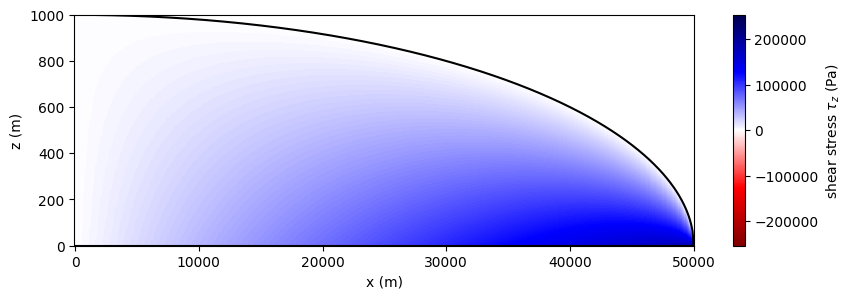

In [6]:
s_prime = np.gradient(s, x)
τ_z = -ρ*g*(S - Z)*s_prime
τ_z = np.where(ice_mask, τ_z, np.nan)

from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter = 0)

plt.figure(figsize=(10, 3))
stress_plot = plt.pcolormesh(x, z, τ_z, cmap = 'seismic_r', norm = norm)
plt.plot(x, s, color = 'k')
plt.plot(x, b, color = 'k')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.colorbar(stress_plot, label = 'shear stress $τ_z$ (Pa)')
plt.show()

We can see that the shear stress is most pronounced *_near the bed beneath the steepest parts of the glacier_*. This makes sense, since flow is driven by surface slope, and the bed is the primary obstacle providing resistance to that flow. Looking at Equation 2, we should expect that $\tau_z$ increases linearly with depth, which we can verify by plotting a cross-section of our stress solution:

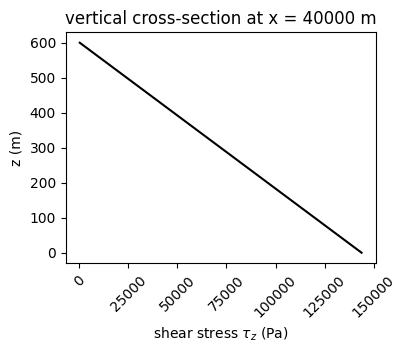

In [7]:
x_1 = 0.8*x_t #choose the point x_1, along which we'll plot a vertical cross-section
i_x1 = np.argmin(np.abs(x - x_1))  #find nearest x-index

plt.figure(figsize = (4, 3))
plt.plot(τ_z[:, i_x1], z, color = 'k')
plt.xlabel('shear stress $τ_z$ (Pa)')
plt.xticks(rotation = 45)
plt.ylabel('z (m)')
plt.title(f'vertical cross-section at x = {x_1:.0f} m')
plt.show()

## Relating the stress field to velocities

In solid mechanics, applying a stress to a an object causes deformation, and that deformation is undone once the force is removed. For example, think of applying a tensile force to pull a spring apart: the spring stretches, but reverts to its baseline as soon as you let go. In contrast, applying the same force to a fluid causes permanent deformation which continues to accumulate at a certain rate for as long as the stress is applied. 

For ice, the relationship between the deformation rate and the applied stress is given by *_Glen's Flow Law_*. For the Shallow Ice Approximation, Glen's Flow Law states that the shear stress $\tau_z$ causes the flow velocity, $u$, to vary with depth via the power law relationship below.

\begin{equation}
\frac{\partial}{\partial z}u = 2A|\tau_z|^{n - 1}\tau_z
\tag{3}
\end{equation}

Here, $n$ is the *_flow exponent_*, which is typically taken by glaciologists to be 3. The *_rate factor_* $A$ is a measure of ice malleability, with larger values corresponding to softer, less rigid ice. $A$ relates to temperature, $T$, via the *_Arrhenius relation_* below: 

\begin{equation}
A = A_0 e^{-\frac{Q}{R}(\frac{1}{T} - \frac{1}{T_t})}
\tag{4}
\end{equation}

With values for the *_prefactor_* $A_0$, *_activation energy_* $Q$, *_gas constant_* $R$, and *_transition temperature_* $T_t$, we can directly calculate the rate factor based on a choice of temperature: 

In [8]:
temp_C = 0 #ice temperature in Celsius 

In [9]:
temp_K = temp_C + 273.15 #temperature in Kelvin
T_t = 263.15 #transition temperature (K)
Q = 6e4 if temp_K < T_t else 115e3 #activation enegy (J/mol), depends on temperature
A_0 = 3.5e-25 #rate prefactor (s^-1 Pa^-3)
R = 8.314 #gas constant (J mol^-1 K^-1)
n = 3 #flow exponent

A = A_0*np.exp(-Q/R*(1/temp_K - 1/263)) #final rate factor (s^-1 Pa^-3)

With the rate factor now a known quantity, we can obtain an analytic solution for the horizontal velocity $u$ by substituting $\tau_z$ from Equation 2 into the right-hand side of Equation 3, and then integrating vertically from the glacier base. This produces

\begin{equation}
u = \frac{-2A}{n + 1}(\rho g s')^{n - 1}\rho gs'\left([s - b]^{n + 1} - [s - z]^{n + 1}\right)
\tag{5}
\end{equation}

In [10]:
u = -2*A/(n + 1)*(ρ*g*s_prime)**(n - 1)*ρ*g*s_prime*((S - B)**(n + 1) - (S - Z)**(n + 1))
u *= 60*60*24*365.25 #since glacier flow is fairly slow in the Shallow Ice Approximation, change from m/s to m/yr
u = np.where(ice_mask, u, np.nan) #and evaluate only over the ice domain

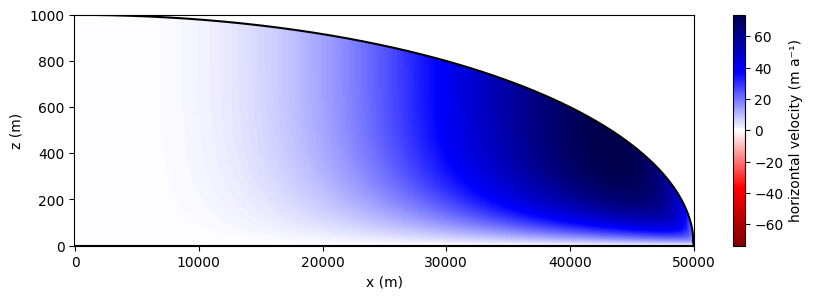

In [11]:
plt.figure(figsize=(10, 3))
norm = TwoSlopeNorm(vcenter = 0)
u_plot = plt.pcolormesh(X, Z, u, cmap = 'seismic_r', norm = norm)
plt.plot(x, s, color = 'k')
plt.plot(x, b, color = 'k')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.colorbar(u_plot, label = 'horizontal velocity (m a⁻¹)')
plt.show()

*_How does this plot change if we select a different temperature in Cell 8?_*

As with the vertical shear stress, we can look at a single cross-section to try to build intuition about how velocity changes with depth. For ease of comparison, we can add the velocity curve to the same plot from before:

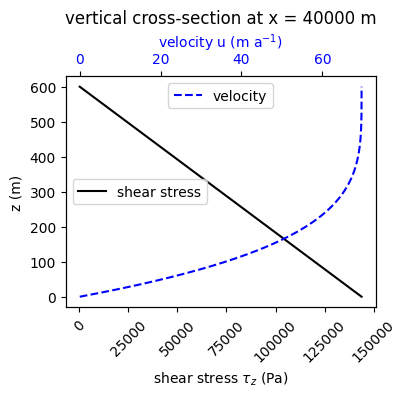

In [12]:
plt.figure(figsize = (4, 3))
plt.title(f'vertical cross-section at x = {x_1:.0f} m')
plt.plot(τ_z[:, i_x1], z, color = 'k', label = 'shear stress')
plt.xlabel('shear stress $τ_z$ (Pa)')
plt.xticks(rotation = 45)
plt.ylabel('z (m)')
plt.legend(loc = 'center left')

plt.twiny()

plt.plot(u[:, i_x1], z, color = 'blue', linestyle = 'dashed', label = 'velocity')
plt.xlabel('velocity u (m a$^{-1}$)', color = 'blue')
plt.xticks(color = 'blue')
plt.legend(loc = 'upper center')

plt.show()

If we look near the surface, the velocity of the ice doesn't change much with depth at first. As we approach the bed, however, velocity begins to rapidly slow down. How does this compare with the values of the shear stress near the surface? Near the base? Does this plot make sense alongside the interpretation that *_basal shear stress resists flow_*?

## Strain rates and vertical velocities

In the case above, ice near the terminus (the right side) is flowing more quickly than ice upstream (the left side). You can imagine that, if this continues over time, the shape of the glacier will become longer. The rate of lengthening is often symbolized $\dot{\varepsilon}_x$ (the *_longitudinal strain rate_*) and it is simply the gradient of the horizontal velocity in the $x$ direction:

\begin{equation}
\dot{\varepsilon}_{x} = \frac{\partial}{\partial x}u
\tag{6}
\end{equation}

In [13]:
ε_x = np.gradient(np.where(ice_mask, u, 0.), x, axis = 1) #horizontal stretching rate

Whenever ice speeds up in the along-flow direction, the velocity gradient is positive, producing a positive lengthening rate $\dot{\varepsilon}_{x}$. In some situations, flow may slow down along-flow, in which case $\dot{\varepsilon}_{x}$ is negative, and the glacier becomes shorter.

However, ice is an *_incompressible material_*. This means that (unless the glacier undergoes accumulation or melt) total volume must not change: any lenthening in the horizontal direction must be associated with thinning in the vertical direction. Therefore, we also need to consider the vertical strain rate, $\dot{\varepsilon}_{z}$. Similar to the definition of the longitudinal strain rate, the vertical strain rate is just

\begin{equation}
\dot{\varepsilon}_{z} = \frac{\partial}{\partial z}w,
\tag{7}
\end{equation}

where $w$ is the vertical velocity component: the rate at which glacier ice flows upward or downward to balance any horizontal extension. In our 2D cross-section, there is a particularly simple relationship describing the balance horizontal and vertical strain rates: 

\begin{equation}
\dot{\varepsilon}_{x} + \dot{\varepsilon}_{z} = 0
\tag{8}
\end{equation}

That is, the net rate of stretching between the horizontal and the vertical must be zero. This means that we can directly calculate the vertical strain rate.

In [14]:
ε_z = -ε_x #vertical thinning rate, by Equation 8

From here, we can use Equation 6 to recover the vertical velocity field itself, $w$. We can do this numerically, by taking cumulative summations of $\dot{\varepsilon}_z$ over the domain.

In [15]:
w = np.cumsum(ε_z, axis = 0)*Δz #vertical velocity as the cumulative summations of ε_z, by Equation 7
w = np.where(ice_mask, w, np.nan)

We'll add a subplot of the vertical velocity $w$ to our earlier plot of the horizontal velocity to facilitate comparison:

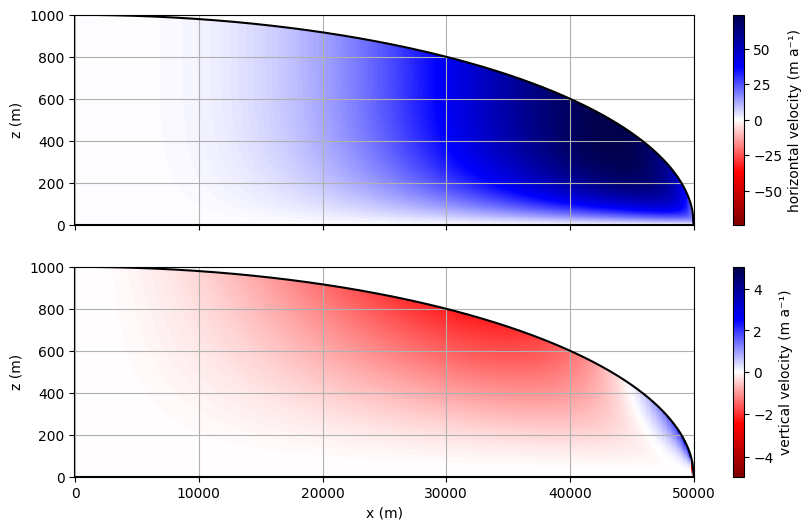

In [16]:
fig, axs = plt.subplots(2, 1, figsize = (10, 6), sharex = True)

###########################
### horizontal velocity ###
###########################

norm = TwoSlopeNorm(vcenter = 0)
u_plot = axs[0].pcolormesh(X, Z, u, norm = norm, cmap = 'seismic_r')
axs[0].plot(x, s, color = 'k')
axs[0].plot(x, b, color = 'k')
axs[0].set_ylabel('z (m)')
axs[0].grid()
fig.colorbar(u_plot, ax = axs[0], label = 'horizontal velocity (m a⁻¹)')


#########################
### vertical velocity ###
#########################

norm = TwoSlopeNorm(vcenter = 0)
w_plot = axs[1].pcolormesh(X, Z, w, cmap='seismic_r', norm = norm)
axs[1].plot(x, s, color = 'k')
axs[1].plot(x, b, color = 'k')
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('x (m)')
axs[1].grid()
fig.colorbar(w_plot, ax=axs[1], label='vertical velocity (m a⁻¹)')

plt.show()

Notice that the vertical velocity is negative wherever ice is speeding up along-flow, and upward in the small near-terminus zone where $u$ is slowing down. This may be easier to see in a horizontal cross-section:

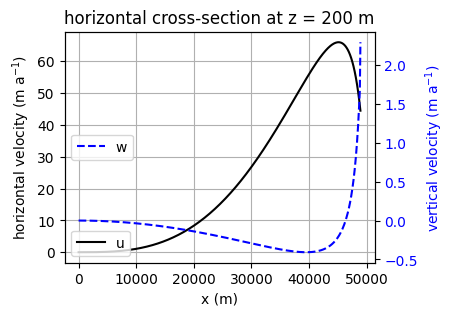

In [17]:
z_1 = 0.2*dome_height #choose the point z_1, along which we'll plot a horizontal cross-section
i_z1 = np.argmin(np.abs(z - z_1))  #find nearest x-index

plt.figure(figsize = (4, 3))
plt.title(f'horizontal cross-section at z = {z_1:.0f} m')
plt.plot(x, u[i_z1, :], color = 'k', label = 'u')
plt.xlabel('x (m)')
plt.ylabel('horizontal velocity (m a$^{-1}$)')
plt.legend(loc = 'lower left')
plt.grid()

plt.twinx()

plt.plot(x, w[i_z1, :], color = 'blue', linestyle = 'dashed', label = 'w')
plt.ylabel('vertical velocity (m a$^{-1}$)', color = 'blue')
plt.yticks(color = 'blue')
plt.legend(loc = 'center left')
plt.show()

plt.show()

*_How does this observation relate to the concept of incompressibility? How does it relate to Equation 8?_*

Finally, we can plot the total speed (the magnitude of the velocity) as a streamplot to more directly visualize the true direction of flow within the ice:

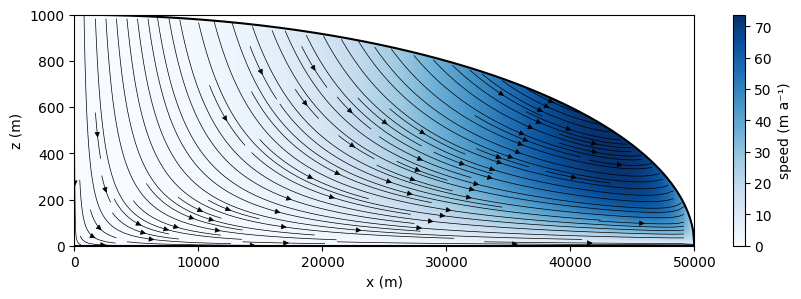

In [18]:
speed = np.hypot(u, w)

plt.figure(figsize=(10, 3))
speed_plot = plt.pcolormesh(X, Z, speed, cmap = 'Blues')
plt.streamplot(x, z, u, w, color='k', density = 2, linewidth = 0.5, arrowsize=0.8)
plt.plot(x, s, color = 'k')
plt.plot(x, b, color = 'k')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.ylim(0, dome_height)
plt.xlim(x_0, x_t)
plt.colorbar(speed_plot, label = 'speed (m a⁻¹)')
plt.show()

## Thickness change due to flow

As you can probably imagine from the plot above, the motion described by the Shallow Ice Approximation redistributes ice, changing the shape of the glacier. For example, even without a description of melt or accumulation, the flowlines above show that the surface should lower and mass should move to the right. How might this impact how the glacier looks after some specified amount of time? 

We can think about this problem by considering the *_ice flux_*, or the total amount of ice conveyed forward through a vertical slice of the glacier. This quantity, often symbolized $q$, is given as the depth-integrated forward velocity, from the base to the surface, with 

\begin{equation}
q = \int_s^budz
\tag{9}
\end{equation}

You can verify from Equation 9 that, in this 2D example, ice flux is measured in area over time. To make sense of these units, you can imagine ice flux as the area conveyed forward by the velocity field across each vertical slice: 

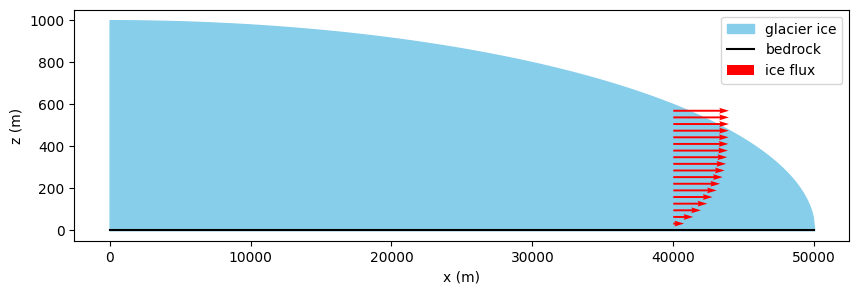

In [19]:
plt.figure(figsize = (10, 3))
plt.fill_between(x, b, s, color = 'skyblue', label = 'glacier ice')
plt.plot(x, b, color = 'k', label = 'bedrock')

z_col = np.linspace(b[i_x1], s[i_x1], 20)
u_col = np.interp(z_col, z, u[:, i_x1])
plt.quiver([x_1]*len(z_col), z_col, u_col, 0, color = 'red', width = 0.0025, label = 'ice flux')

plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.legend(loc = 'upper right')
plt.show()

In the figure above, we can visualize the ice flux, $q$, as the area covered by the red arrows, per unit time. *_How does this figure relate to the vertical velocity curve plotted in Cell 12?_*

Ice flux can be calculated by evaluating Equation 9 numerically:

In [20]:
u_depth_averaged = np.nanmean(u, axis = 0)
q = u_depth_averaged*(s - b) #Equation 8 is equivalent to multiplying the depth-averaged velocity by the thickness

The rate of thickness change relates to ice flux via the mass conservation equation below. 

\begin{equation}
\dot{H} + \frac{\partial}{\partial x}q = 0
\tag{10}
\end{equation}

In this equation, we have symbolized the rate of thicknes change over time as $\dot{H}$. 

In [21]:
H_dot = -np.gradient(q, x) #by Equation 9
H_dot[-1] = 0 #to get rid of weird boundary effects
H_dot[0] = 0 if x_0 < 0 else H_dot[0] #don't worry too much about this 

Now, after flow continues for some amount of time, $\Delta t$, the total amount of thickness change over that timespan is just $\dot{H}\Delta t$. The new surface elevation, therefore, can be approximated by modifying the old surface elevation by precisely this amount.$^*$

$^*$ *_Caveat: Unfortunately, forward-timestepping thickness updates are horribly numerically unstable. In practice, implicit timestepping techniques are used to adjust glacier thickness over time. To avoid adding this layer of complexity here, we've stuck with the bad habit of directly adjusting the surface elevation. But be warned that this will probably blow up with certain parameter choices. If the plot below breaks, try setting $\Delta t$ much smaller._*

In [22]:
Δt = 10 #timestep in years
s_new = s + H_dot*Δt #new surface elevation

The change in glacier shape after $\Delta t$ years of flow is shown below. 

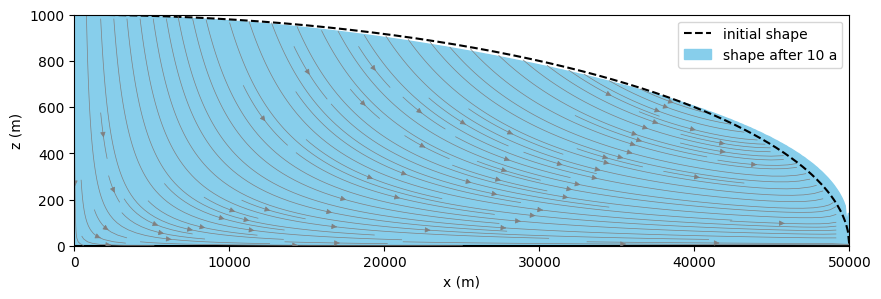

In [23]:
plt.figure(figsize=(10, 3))
plt.plot(x, s, color = 'k', linestyle = 'dashed', label = 'initial shape')
plt.plot(x, b, color = 'k')
plt.fill_between(x, b, s_new, color = 'skyblue', label = f'shape after {Δt} a')
plt.streamplot(x, z, u, w, color='0.5', density = 2, linewidth = 0.5, arrowsize=0.8)
plt.legend(loc = 'upper right')
plt.xlim(x_0, x_t)
plt.ylim(0, dome_height)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()

## Epilogue: A time-evolving model

In [24]:
# Δt = 1/1000
# model_time = 10 #the number of years we'll model 
# num_timesteps = int(model_time/Δt)

# s_original = np.copy(s)
# surface_evolution = []

# import time
# start_time = time.time()

# for timestep in range(num_timesteps):
    
#     s_prime = np.gradient(s, x)
    
#     u = -2*A/(n + 1)*(ρ*g*s_prime)**(n - 1)*ρ*g*s_prime*((S - B)**(n + 1) - (S - Z)**(n + 1))
#     u *= 60*60*24*365.25 
#     u = np.where(ice_mask, u, np.nan) 

#     u_depth_averaged = np.nanmean(u, axis = 0)
#     q = u_depth_averaged*(s - b) 

#     H_dot = -np.gradient(q, x) 
#     H_dot[-1] = 0 
#     H_dot[0] = 0 if x_0 < 0 else H_dot[0] 

#     s = s + H_dot*Δt 
#     S = s[None, :]
#     ice_mask = (Z >= B) & (Z <= S)

#     seconds_per_iteration = (time.time() - start_time)/(timestep + 1)
#     iterations_remaining = num_timesteps - timestep
#     seconds_remaining = iterations_remaining*seconds_per_iteration

#     if (timestep + 1)*Δt % 1 == 0:
#         print(f'{(timestep + 1)*Δt:.0f} of {model_time} years simulated (estimated time remaining: {seconds_remaining:.0f} seconds)')
#         surface_evolution.append(s)

# s = np.copy(s_original)
# S = s[None, :]
# ice_mask = (Z >= B) & (Z <= S)

In [25]:
# plt.figure(figsize = (10, 3))
# for entry in surface_evolution:
#     plt.plot(x, entry)